In [1]:
#Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint

In [2]:
#Create dataframe for Air Quality data from csv files.
aq2020_df = pd.read_csv("Resources/aq2020.csv")
aq2019Q1_df = pd.read_csv("Resources/aq2019Q1.csv")
aq2019Q2_df = pd.read_csv("Resources/aq2019Q2.csv")
aq2019Q3_df = pd.read_csv("Resources/aq2019Q3.csv")

#Create a df to hold all of 2019 data
aq2019_df=pd.concat([aq2019Q1_df,aq2019Q2_df,aq2019Q3_df])

#Format dataframe dates
aq2020_df['Date']= pd.to_datetime(aq2020_df['Date'])
aq2019_df['Date']= pd.to_datetime(aq2019_df['Date'])

In [3]:
#Drop nullvalues and clean AQ data

#drop null values and reset index 2020
clean_aq2020_df = aq2020_df.dropna(how='any')
clean_aq2020_df.reset_index(inplace=True)
del clean_aq2020_df['index']
clean_aq2020_df

#drop null values and reset index 2020
clean_aq2019_df = aq2019_df.dropna(how='any')
clean_aq2019_df.reset_index(inplace=True)
del clean_aq2019_df['index']
clean_aq2019_df

,Date,Country,City,Specie,count,min,max,median,variance
0,2019-01-16,AE,Abu Dhabi,pm10,24.0,86.0,99.0,97.0,179.40
1,2019-01-22,AE,Abu Dhabi,pm10,24.0,51.0,57.0,55.0,23.75
2,2019-01-26,AE,Abu Dhabi,pm10,24.0,136.0,173.0,160.0,941.96
3,2019-01-07,AE,Abu Dhabi,pm10,24.0,60.0,91.0,72.0,1006.88
4,2019-01-10,AE,Abu Dhabi,pm10,24.0,82.0,93.0,87.0,57.97
...,...,...,...,...,...,...,...,...,...
1596666,2019-07-09,HU,Budapest,wind-gust,282.0,0.1,12.6,4.4,109.64
1596667,2019-07-18,HU,Budapest,wind-gust,338.0,0.1,9.7,3.4,37.78
1596668,2019-07-21,HU,Budapest,wind-gust,337.0,0.1,17.9,3.8,137.24
1596669,2019-07-24,HU,Budapest,wind-gust,325.0,0.2,6.1,2.7,33.09


In [4]:
#Covid API URL
base_url = "https://api.covid19api.com/dayone/country/"
end_url = "/status/confirmed"

#Lists to hold call data
Country_list=['Germany','Italy','New Zealand','Spain','Brazil','USA','China','Japan']
Covid_date=[]
Covid_city=[]
Covid_province=[]
Covid_country_code=[]
Covid_cases=[]


# Loop through the list of coutries and perform a request for data on each
print("Beginning Data Retrieval")
print("--------------------------")
for country in Country_list:
    response = requests.get(base_url+country+end_url).json()
    response
    for i in range(len(response)):
        #exception handling  
        try:  
            #store covid data into respective variables
            Covid_date.append(response[i]['Date'])
            Covid_country_code.append(response[i]['CountryCode'])
            Covid_city.append(response[i]['City'])
            Covid_province.append(response[i]['Province'])
            Covid_cases.append(response[i]['Cases'])
        except KeyError:
            print("Coutry not found. Skipping...")
print("-----------------------------")
print("Data Retrieval Complete")      
print("-----------------------------")

Beginning Data Retrieval
--------------------------
-----------------------------
Data Retrieval Complete
-----------------------------


In [5]:
#Create a dictionary from call lists

covid_dict = {
    "Date": Covid_date,
    "Country": Covid_country_code,
    "Province": Covid_province,
    "City":Covid_city,
    "Cases": Covid_cases
}

#Convert dictionary to dataframe
Covid_data = pd.DataFrame(covid_dict)


#Format covid dataframe dates (now mergable with air quality dataframes)
Covid_data['Date'] = Covid_data['Date'].str.strip('T00:00:00Z')
Covid_data['Date'] = pd.to_datetime(Covid_data['Date'])

#Drop duplicates
Clean_Covid_data= Covid_data.drop_duplicates(["City", "Date", "Country","Province" ], keep = 'first')
Clean_Covid_data

,Date,Country,Province,City,Cases
0,2020-01-27,DE,,,1
1,2020-01-28,DE,,,4
2,2020-01-29,DE,,,4
3,2020-01-03,DE,,,4
4,2020-01-31,DE,,,5
...,...,...,...,...,...
362548,2020-07-16,JP,,,23510
362549,2020-07-17,JP,,,24104
362550,2020-07-18,JP,,,24946
362551,2020-07-19,JP,,,25446


In [6]:
#Define a function to create Linear Regression plots

def L_regress(x_value, y_value, x_lbl, y_lbl,title,linepos,fignum):
    
    # Perform a linear regression
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_value, y_value)

    # Get regression values
    regress_value = x_value * slope + intercept
    
    # Print r square value
    print(f"The r-squared is: {rvalue**2}")
    
    #calculate correlation coefficient and print
    correlation = st.pearsonr(x_value,y_value)
    print(f"The correlation between covid cases and Air quality Pm2.5 value is {round(correlation[0],2)}")
    
    # Create Plot
    plt.scatter(x_value,y_value, marker="o", facecolors="blue", edgecolors="black", alpha=0.75)
    plt.plot(x_value,regress_value,"r-")
    plt.grid(b=None, which='major', axis='both')
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    #Label plot and annotate the line equation
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.title(title)
    plt.annotate(line_eq,linepos,fontsize=15,color="red")

    #save figure 
    plt.savefig(f"output_data_us/fig{fignum}.png")

    # Show plot
    plt.show()

In [7]:
#Define a function to create line subplots for covid cases and air quality for 2020

def covid_aq_plot(x_value, y_value,y_covid_value,y_lbl,title,fignum):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Date')
    plt.xticks(rotation=45)
    ax1.set_ylabel('Case Number', color=color)
    ax1.plot(x_value, y_covid_value, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.title(title)
    ax2 = ax1.twinx()
    color2020 = 'tab:blue'
    ax2.set_ylabel(y_lbl, color=color2020)
    ax2.plot(x_value, y_value, color=color2020)
    ax2.tick_params(axis='y', labelcolor=color2020)
    fig.tight_layout()
    
    #save figure 
    plt.savefig(f"output_data_us/fig{fignum}.png")
    
    # Show plot
    plt.show()

In [8]:
# define a function to do statistical T-test and plot histogram
def Ttest_hist(AQ2019, AQ2020, lbl2019, lbl2020 ,title,fignum):
    
    #Plot Histogram
    plt.hist(AQ2019, 10, density=True, alpha=0.7, label=lbl2019)
    plt.hist(AQ2020, 10, density=True, alpha=0.7, label=lbl2020)
    plt.axvline(AQ2019.mean(), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(AQ2020.mean(), color='orange', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel('AQ')
    plt.ylabel('Pvalue')
    plt.legend()
    
    #save figure 
    plt.savefig(f"output_data_us/fig{fignum}.png")
    
    #Show plot
    plt.show()

In [9]:
#Combine air quality 2019 and 2020 dataframes
AQ_US = pd.concat([clean_aq2019_df, clean_aq2020_df])

#Reformat dataframes, pull specie out, convert into columns

#Boston
aq_boston = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Boston')]
bospm25 = aq_boston.loc[aq_boston['Specie']=='pm25']
bospm25.rename(columns={"median": "pm25"}, inplace=True)
bospm25 = bospm25[['Date','pm25']]
bosco = aq_boston.loc[aq_boston['Specie']=='co']
bosco.rename(columns={"median": "co"}, inplace=True)
bosco = bosco[['Date','co']]
bosno2 = aq_boston.loc[aq_boston['Specie']=='no2']
bosno2.rename(columns={"median": "no2"}, inplace=True)
bosno2 = bosno2[['Date','no2']]
aq_boston_final = pd.merge(bospm25, bosco, how="inner", on=["Date"])
aq_boston_final = pd.merge(aq_boston_final, bosno2, how="inner", on=["Date"])
aq_boston_final = aq_boston_final.sort_values(by='Date')

#Charlotte
aq_char = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Charlotte')]
charpm25 = aq_char.loc[aq_char['Specie']=='pm25']
charpm25.rename(columns={"median": "pm25"}, inplace=True)
charpm25 = charpm25[['Date','pm25']]
charco = aq_char.loc[aq_char['Specie']=='co']
charco.rename(columns={"median": "co"}, inplace=True)
charco = charco[['Date','co']]
aq_char_final = pd.merge(charpm25, charco, how="inner", on=["Date"])
aq_char_final = aq_char_final.sort_values(by='Date')

#Los Angeles
aq_la = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Los Angeles')]
lapm25 = aq_la.loc[aq_la['Specie']=='pm25']
lapm25.rename(columns={"median": "pm25"}, inplace=True)
lapm25 = lapm25[['Date','pm25']]
laco = aq_la.loc[aq_la['Specie']=='co']
laco.rename(columns={"median": "co"}, inplace=True)
laco = laco[['Date','co']]
lano2 = aq_la.loc[aq_la['Specie']=='no2']
lano2.rename(columns={"median": "no2"}, inplace=True)
lano2 = lano2[['Date','no2']]
aq_la_final = pd.merge(lapm25, laco, how="inner", on=["Date"])
aq_la_final = pd.merge(aq_la_final, lano2, how="inner", on=["Date"])
aq_la_final = aq_la_final.sort_values(by='Date')

#Seattle
aq_sea = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Seattle')]
seapm25 = aq_sea.loc[aq_sea['Specie']=='pm25']
seapm25.rename(columns={"median": "pm25"}, inplace=True)
seapm25 = seapm25[['Date','pm25']]
seaco = aq_sea.loc[aq_sea['Specie']=='co']
seaco.rename(columns={"median": "co"}, inplace=True)
seaco = seaco[['Date','co']]
seano2 = aq_sea.loc[aq_sea['Specie']=='no2']
seano2.rename(columns={"median": "no2"}, inplace=True)
seano2 = seano2[['Date','no2']]
aq_sea_final = pd.merge(seapm25, seaco, how="inner", on=["Date"])
aq_sea_final = pd.merge(aq_sea_final, seano2, how="inner", on=["Date"])
aq_sea_final = aq_sea_final.sort_values(by='Date')

#Chicago
aq_chi = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Chicago')]
chipm25 = aq_chi.loc[aq_chi['Specie']=='pm25']
chipm25.rename(columns={"median": "pm25"}, inplace=True)
chipm25 = chipm25[['Date','pm25']]
chico = aq_chi.loc[aq_chi['Specie']=='co']
chico.rename(columns={"median": "co"}, inplace=True)
chico = chico[['Date','co']]
chino2 = aq_chi.loc[aq_chi['Specie']=='no2']
chino2.rename(columns={"median": "no2"}, inplace=True)
chino2 = chino2[['Date','no2']]
aq_chi_final = pd.merge(chipm25, chico, how="inner", on=["Date"])
aq_chi_final = pd.merge(aq_chi_final, chino2, how="inner", on=["Date"])
aq_chi_final = aq_chi_final.sort_values(by='Date')

#Omaha
aq_oma = AQ_US.loc[(AQ_US['Country']=='US') & (AQ_US['City']=='Omaha')]
omapm25 = aq_oma.loc[aq_oma['Specie']=='pm25']
omapm25.rename(columns={"median": "pm25"}, inplace=True)
omapm25 = omapm25[['Date','pm25']]
omaco = aq_oma.loc[aq_oma['Specie']=='co']
omaco.rename(columns={"median": "co"}, inplace=True)
omaco = omaco[['Date','co']]
aq_oma_final = pd.merge(omapm25, omaco, how="inner", on=["Date"])
aq_oma_final = aq_oma_final.sort_values(by='Date')

C:\Users\Alex\anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
#Narrow down dataframe to US data
US_covid = Covid_data.loc[Covid_data['Country']=='US']

#Filter data for county containing city, clean duplicates, and group by date.

#Boston
covid_boston = US_covid.loc[(US_covid['Province']=='Massachusetts') & (US_covid['City']=='Suffolk')]
covid_boston = covid_boston.drop_duplicates(["City", "Date"], keep = 'first')
covid_boston = covid_boston[['Date', 'Cases']].groupby('Date').mean()

#Charlotte
covid_char = US_covid.loc[(US_covid['Province']=='North Carolina') & (US_covid['City']=='Mecklenburg')]
covid_char = covid_char.drop_duplicates(["City", "Date"], keep = 'first')
covid_char = covid_char[['Date', 'Cases']].groupby('Date').mean()

#Los Angeles
covid_la = US_covid.loc[(US_covid['Province']=='California') & (US_covid['City']=='Los Angeles')]
covid_la = covid_la.drop_duplicates(["City", "Date"], keep = 'first')
covid_la = covid_la[['Date', 'Cases']].groupby('Date').mean()

#Seattle
covid_seattle = US_covid.loc[(US_covid['Province']=='Washington') & (US_covid['City']=='King')]
covid_seattle = covid_seattle.drop_duplicates(["City", "Date"], keep = 'first')
covid_seattle = covid_seattle[['Date', 'Cases']].groupby('Date').mean()

#Chicago
covid_chicago = US_covid.loc[(US_covid['Province']=='Illinois') & (US_covid['City']=='Cook') | (US_covid['City']=='DuPage')]
covid_chicago = covid_chicago.drop_duplicates(["City", "Date"], keep = 'first')
covid_chicago = covid_chicago[['Date', 'Cases']].groupby('Date').mean()

#Omaha
covid_omaha = US_covid.loc[(US_covid['Province']=='Nebraska') & (US_covid['City']=='Douglas')]
covid_omaha = covid_omaha.drop_duplicates(["City", "Date"], keep = 'first')
covid_omaha = covid_omaha[['Date', 'Cases']].groupby('Date').mean()

Stats for pm25: Ttest_indResult(statistic=4.560026393931823, pvalue=6.927113715170049e-06)
The r-squared is: 0.0008484264252381781
The correlation between covid cases and Air quality Pm2.5 value is -0.03


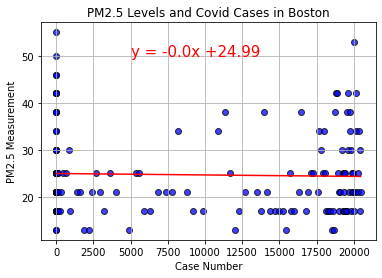

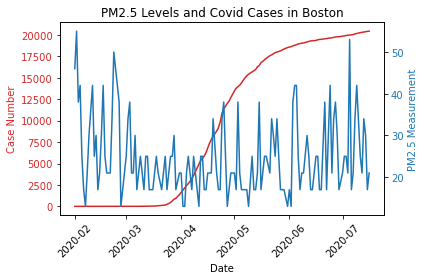

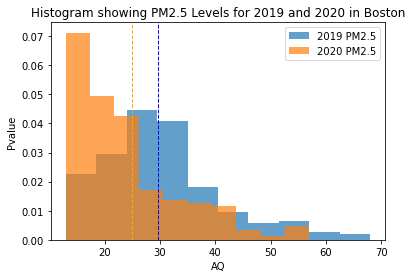

Stats for co: Ttest_indResult(statistic=1.5995055277854469, pvalue=0.11062694691045288)
The r-squared is: 0.193276071710826
The correlation between covid cases and Air quality Pm2.5 value is -0.44


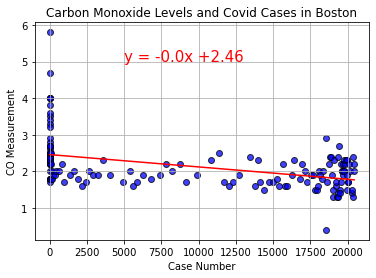

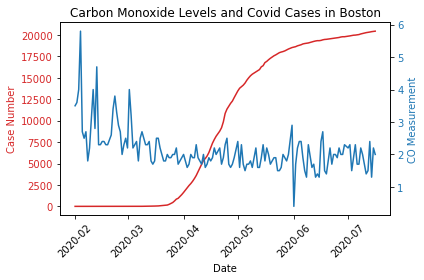

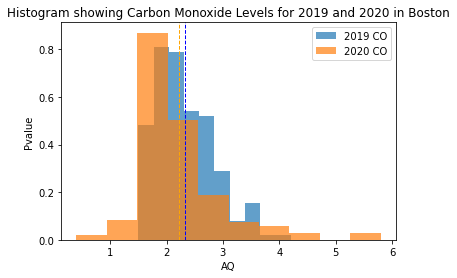

Stats for no2: Ttest_indResult(statistic=2.7667258915519084, pvalue=0.005958515241312427)
The r-squared is: 0.2463670121974237
The correlation between covid cases and Air quality Pm2.5 value is -0.5


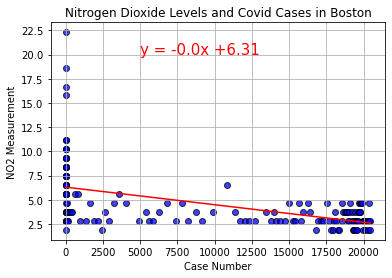

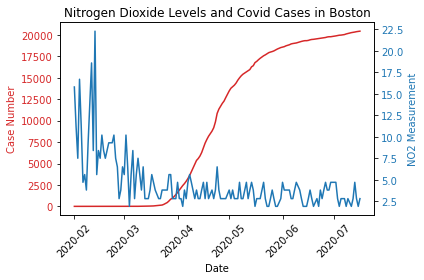

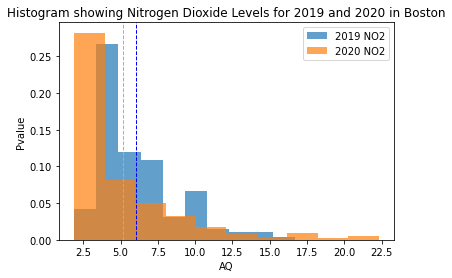

In [11]:
#----------------------------------------------------------------------------------
#Analysis of Boston
#----------------------------------------------------------------------------------

#Create air quality dataframes and Covid-AQ comparison dataframes
Bosaq19 = aq_boston_final.loc[(aq_boston_final['Date']>="2019-01-01") & (aq_boston_final['Date']<="2019-07-16")]
Bosaq20 = aq_boston_final.loc[((aq_boston_final['Date']>="2020-01-01") & (aq_boston_final['Date']<="2020-07-16"))]

boscompare = pd.merge(covid_boston, aq_boston_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
# Boston PM.25
#----------------------------------------------------------------------------------

print(f"Stats for pm25: {st.ttest_ind(Bosaq19['pm25'], Bosaq20['pm25'], equal_var=False)}")

L_regress(boscompare['Cases'], boscompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Boston", (5000,50),"BOSscat1")

covid_aq_plot(boscompare['Date'], boscompare['pm25'], boscompare['Cases'], "PM2.5 Measurement", 
              "PM2.5 Levels and Covid Cases in Boston", "BOSline1")

Ttest_hist(Bosaq19['pm25'], Bosaq20['pm25'], "2019 PM2.5", "2020 PM2.5", 
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Boston", "BOShist1")

#----------------------------------------------------------------------------------
# Boston CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Bosaq19['co'], Bosaq20['co'], equal_var=False)}")

L_regress(boscompare['Cases'], boscompare['co'], "Case Number", 'CO Measurement',
          "Carbon Monoxide Levels and Covid Cases in Boston", (5000,5),"BOSscat2")

covid_aq_plot(boscompare['Date'], boscompare['co'], boscompare['Cases'],
              "CO Measurement", "Carbon Monoxide Levels and Covid Cases in Boston", "BOSline2")

Ttest_hist(Bosaq19['co'], Bosaq20['co'], "2019 CO", "2020 CO", 
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Boston", "BOShist2")

#----------------------------------------------------------------------------------
# Boston NO2
#----------------------------------------------------------------------------------

print(f"Stats for no2: {st.ttest_ind(Bosaq19['no2'], Bosaq20['no2'], equal_var=False)}")

L_regress(boscompare['Cases'], boscompare['no2'], "Case Number", 'NO2 Measurement',
          "Nitrogen Dioxide Levels and Covid Cases in Boston", (5000,20),"BOSscat3")

covid_aq_plot(boscompare['Date'], boscompare['no2'], boscompare['Cases'], "NO2 Measurement",
              "Nitrogen Dioxide Levels and Covid Cases in Boston", "BOSline3")

Ttest_hist(Bosaq19['no2'], Bosaq20['no2'], "2019 NO2", "2020 NO2", 
           "Histogram showing Nitrogen Dioxide Levels for 2019 and 2020 in Boston", "BOShist3")


Stats for pm25: Ttest_indResult(statistic=3.5220160888241967, pvalue=0.0005116781324733697)
The r-squared is: 0.11757759472161944
The correlation between covid cases and Air quality Pm2.5 value is 0.34


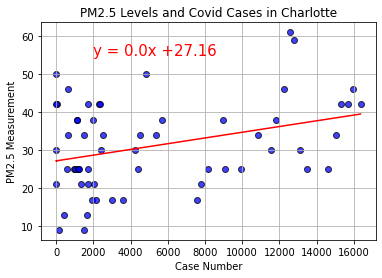

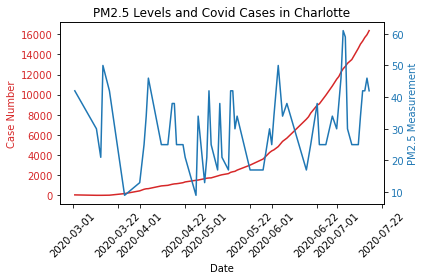

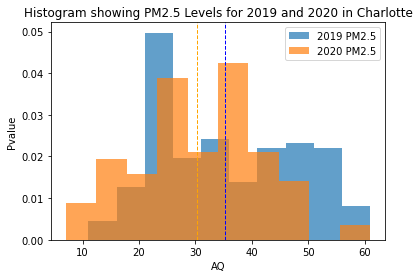

Stats for co: Ttest_indResult(statistic=4.098869496371916, pvalue=5.5199296005272944e-05)
The r-squared is: 0.0007684506175644549
The correlation between covid cases and Air quality Pm2.5 value is -0.03


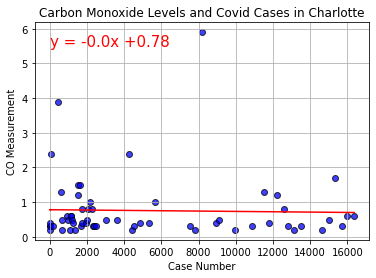

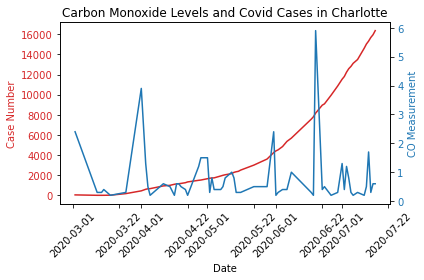

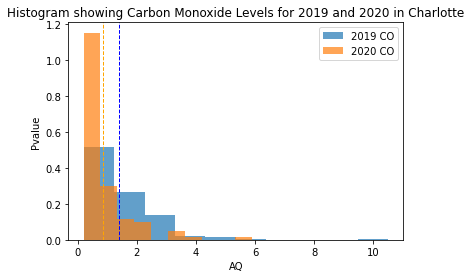

In [12]:
#----------------------------------------------------------------------------------
#Analysis of Charlotte
#----------------------------------------------------------------------------------

Charaq19 = aq_char_final.loc[(aq_char_final['Date']>="2019-01-01") & (aq_char_final['Date']<="2019-07-16")]
Charaq20 = aq_char_final.loc[((aq_char_final['Date']>="2020-01-01") & (aq_char_final['Date']<="2020-07-16"))]

charcompare = pd.merge(covid_char, aq_char_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
#Charlotte PM2.5
#----------------------------------------------------------------------------------

print(f"Stats for pm25: {st.ttest_ind(Charaq19['pm25'], Charaq20['pm25'], equal_var=False)}")

L_regress(charcompare['Cases'], charcompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Charlotte", (2000,55),"CHARscat1")

covid_aq_plot(charcompare['Date'], charcompare['pm25'], charcompare['Cases'], "PM2.5 Measurement", 
              "PM2.5 Levels and Covid Cases in Charlotte", "CHARline1")

Ttest_hist(Charaq19['pm25'], Charaq20['pm25'], "2019 PM2.5", "2020 PM2.5", 
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Charlotte", "CHARhist1")

#----------------------------------------------------------------------------------
#Charlotte CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Charaq19['co'], Charaq20['co'], equal_var=False)}")

L_regress(charcompare['Cases'], charcompare['co'], "Case Number", 'CO Measurement',
          "Carbon Monoxide Levels and Covid Cases in Charlotte", (0,5.5), "CHARscat2")

covid_aq_plot(charcompare['Date'], charcompare['co'], charcompare['Cases'], "CO Measurement",
              "Carbon Monoxide Levels and Covid Cases in Charlotte", "CHARline2")

Ttest_hist(Charaq19['co'], Charaq20['co'], "2019 CO", "2020 CO",
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Charlotte", "CHARhist2")

#>>>>>>>>>>NOTE<<<<<<<<<<<<
#No no2 data available for Charlotte

Stats for pm25: Ttest_indResult(statistic=-1.9607370603565168, pvalue=0.05062106765811685)
The r-squared is: 0.04211037579210588
The correlation between covid cases and Air quality Pm2.5 value is 0.21


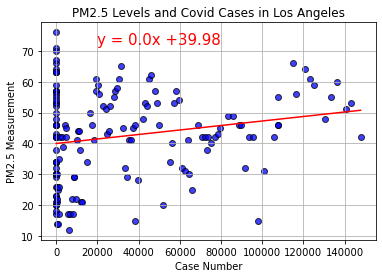

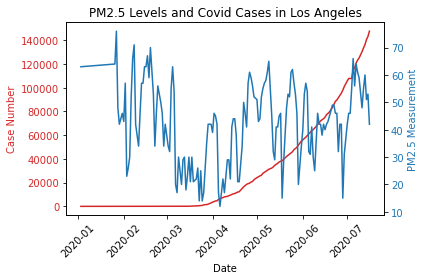

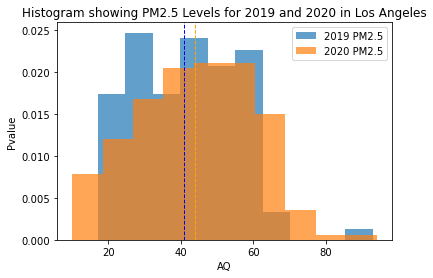

Stats for co: Ttest_indResult(statistic=-1.510170223895591, pvalue=0.13181635029580524)
The r-squared is: 0.1263489036149877
The correlation between covid cases and Air quality Pm2.5 value is -0.36


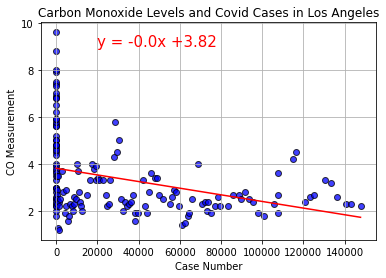

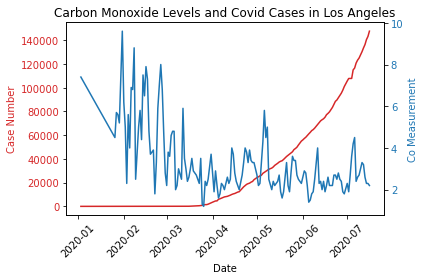

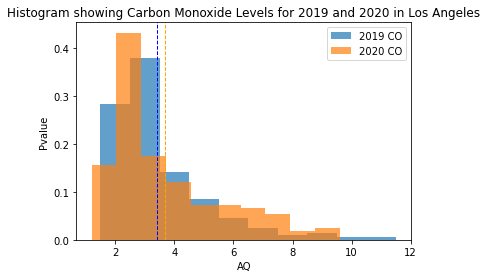

Stats for no2: Ttest_indResult(statistic=0.7602715901903109, pvalue=0.44755107527755866)
The r-squared is: 0.12118181184603036
The correlation between covid cases and Air quality Pm2.5 value is -0.35


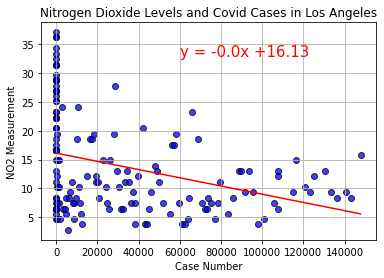

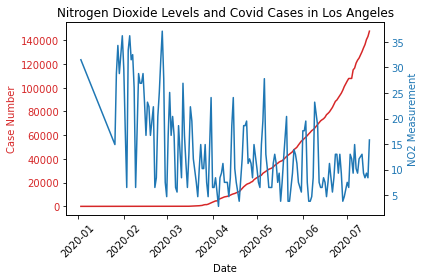

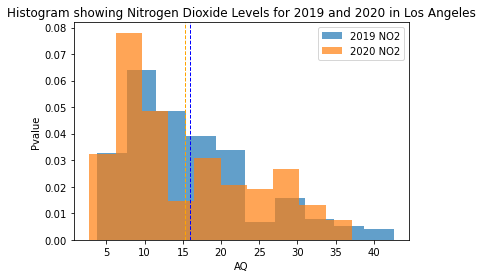

In [13]:
#----------------------------------------------------------------------------------
#Analysis of Los Angeles
#----------------------------------------------------------------------------------

LAaq19 = aq_la_final.loc[(aq_la_final['Date']>="2019-01-01") & (aq_la_final['Date']<="2019-07-16")]
LAaq20 = aq_la_final.loc[((aq_la_final['Date']>="2020-01-01") & (aq_la_final['Date']<="2020-07-16"))]

lacompare = pd.merge(covid_la, aq_la_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
#Los Angeles PM2.5
#----------------------------------------------------------------------------------

print(f"Stats for pm25: {st.ttest_ind(LAaq19['pm25'], LAaq20['pm25'], equal_var=False)}")

L_regress(lacompare['Cases'], lacompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Los Angeles",(20000,72),"LAscat1")

covid_aq_plot(lacompare['Date'], lacompare['pm25'], lacompare['Cases'], "PM2.5 Measurement",
              "PM2.5 Levels and Covid Cases in Los Angeles", "LAline1")

Ttest_hist(LAaq19['pm25'], LAaq20['pm25'], "2019 PM2.5", "2020 PM2.5",
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Los Angeles", "LAhist1")

#----------------------------------------------------------------------------------
#Los Angeles CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(LAaq19['co'], LAaq20['co'], equal_var=False)}")

L_regress(lacompare['Cases'], lacompare['co'], "Case Number", 'CO Measurement',
          "Carbon Monoxide Levels and Covid Cases in Los Angeles", (20000,9), "LAscat2")

covid_aq_plot(lacompare['Date'], lacompare['co'], lacompare['Cases'], "Co Measurement",
              "Carbon Monoxide Levels and Covid Cases in Los Angeles", "LAline2")

Ttest_hist(LAaq19['co'], LAaq20['co'], "2019 CO", "2020 CO",
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Los Angeles", "LAhist2")

#----------------------------------------------------------------------------------
#Los Angeles NO2
#----------------------------------------------------------------------------------

print(f"Stats for no2: {st.ttest_ind(LAaq19['no2'], LAaq20['no2'], equal_var=False)}")

L_regress(lacompare['Cases'], lacompare['no2'], "Case Number", 'NO2 Measurement',
          "Nitrogen Dioxide Levels and Covid Cases in Los Angeles", (60000,33), "LAscat3")

covid_aq_plot(lacompare['Date'], lacompare['no2'], lacompare['Cases'], "NO2 Measurement",
              "Nitrogen Dioxide Levels and Covid Cases in Los Angeles", "LAline3")

Ttest_hist(LAaq19['no2'], LAaq20['no2'], "2019 NO2", "2020 NO2",
           "Histogram showing Nitrogen Dioxide Levels for 2019 and 2020 in Los Angeles", "LAhist3")

Stats for pm25: Ttest_indResult(statistic=5.533421641440249, pvalue=6.112054537894506e-08)
The r-squared is: 0.026318061107167695
The correlation between covid cases and Air quality Pm2.5 value is -0.16


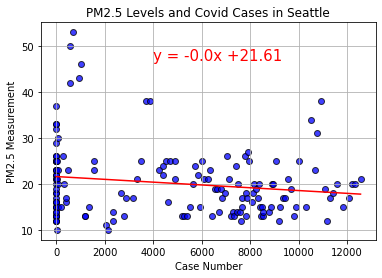

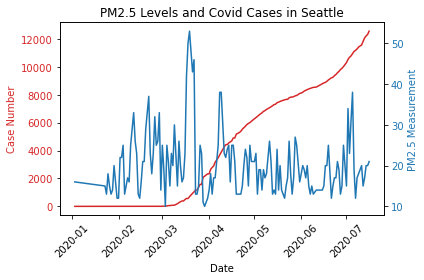

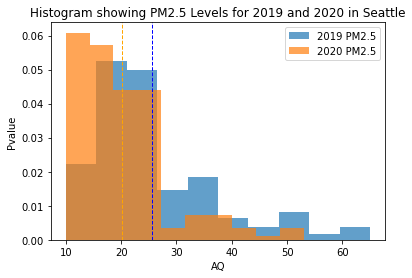

Stats for co: Ttest_indResult(statistic=2.712402021187692, pvalue=0.006989543636478036)
The r-squared is: 0.008684276924071458
The correlation between covid cases and Air quality Pm2.5 value is -0.09


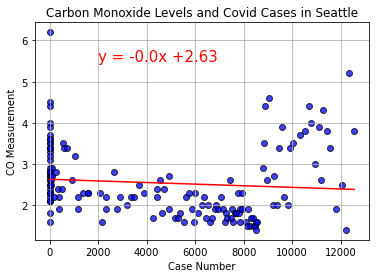

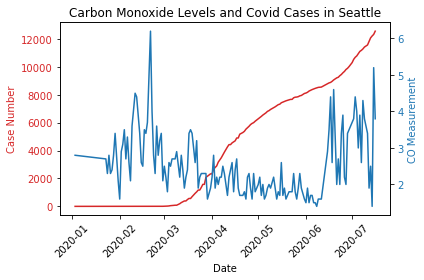

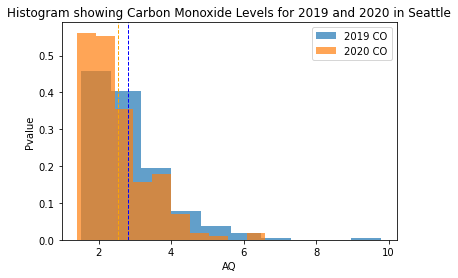

Stats for no2: Ttest_indResult(statistic=4.737937861795785, pvalue=3.0598968370103224e-06)
The r-squared is: 0.3296614333325466
The correlation between covid cases and Air quality Pm2.5 value is -0.57


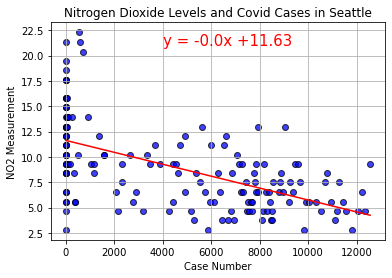

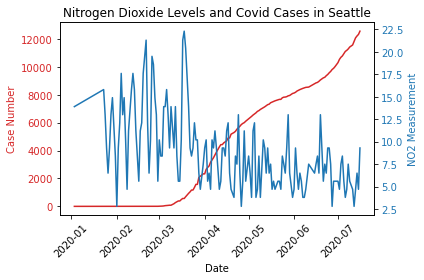

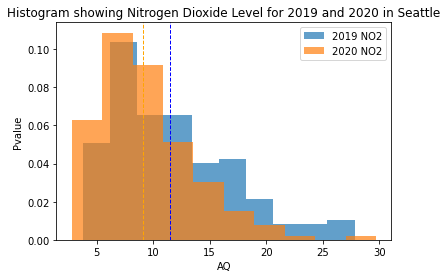

In [14]:
#----------------------------------------------------------------------------------
#Analysis of Seattle
#----------------------------------------------------------------------------------

Seaaq19 = aq_sea_final.loc[(aq_sea_final['Date']>="2019-01-01") & (aq_sea_final['Date']<="2019-07-16")]
Seaaq20 = aq_sea_final.loc[((aq_sea_final['Date']>="2020-01-01") & (aq_sea_final['Date']<="2020-07-16"))]

seacompare = pd.merge(covid_seattle, aq_sea_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
#Seattle PM2.5
#----------------------------------------------------------------------------------

print(f"Stats for pm25: {st.ttest_ind(Seaaq19['pm25'], Seaaq20['pm25'], equal_var=False)}")

L_regress(seacompare['Cases'], seacompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Seattle", (4000,47),"SEAscat1")

covid_aq_plot(seacompare['Date'], seacompare['pm25'], seacompare['Cases'], "PM2.5 Measurement",
              "PM2.5 Levels and Covid Cases in Seattle", "SEAline1")

Ttest_hist(Seaaq19['pm25'], Seaaq20['pm25'], "2019 PM2.5", "2020 PM2.5",
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Seattle", "SEAhist1")

#----------------------------------------------------------------------------------
#Seattle CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Seaaq19['co'], Seaaq20['co'], equal_var=False)}")

L_regress(seacompare['Cases'], seacompare['co'], "Case Number", 'CO Measurement',
          "Carbon Monoxide Levels and Covid Cases in Seattle", (2000,5.5), "SEAscat2")

covid_aq_plot(seacompare['Date'], seacompare['co'], seacompare['Cases'], "CO Measurement",
              "Carbon Monoxide Levels and Covid Cases in Seattle", "SEAline2")

Ttest_hist(Seaaq19['co'], Seaaq20['co'], "2019 CO", "2020 CO",
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Seattle", "SEAhist2")

#----------------------------------------------------------------------------------
#Seattle NO2
#----------------------------------------------------------------------------------

print(f"Stats for no2: {st.ttest_ind(Seaaq19['no2'], Seaaq20['no2'], equal_var=False)}")

L_regress(seacompare['Cases'], seacompare['no2'], "Case Number", 'NO2 Measurement',
          "Nitrogen Dioxide Levels and Covid Cases in Seattle", (4000,21),"SEAscat3")

covid_aq_plot(seacompare['Date'], seacompare['no2'], seacompare['Cases'], "NO2 Measurement",
              "Nitrogen Dioxide Levels and Covid Cases in Seattle", "SEAline3")

Ttest_hist(Seaaq19['no2'], Seaaq20['no2'], "2019 NO2", "2020 NO2",
           "Histogram showing Nitrogen Dioxide Level for 2019 and 2020 in Seattle", "SEAhist3")


Stats for pm25: Ttest_indResult(statistic=3.430568329110544, pvalue=0.0006687957169238892)
The r-squared is: 3.248838021505197e-05
The correlation between covid cases and Air quality Pm2.5 value is -0.01


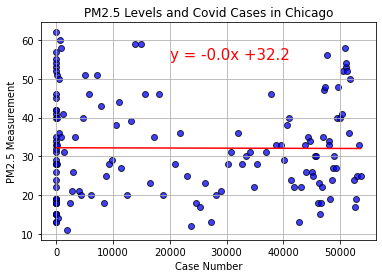

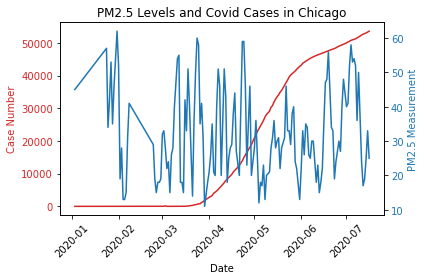

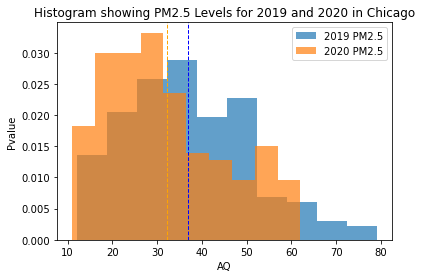

Stats for co: Ttest_indResult(statistic=10.58238294953843, pvalue=5.686981577783925e-23)
The r-squared is: 0.16077137344124096
The correlation between covid cases and Air quality Pm2.5 value is -0.4


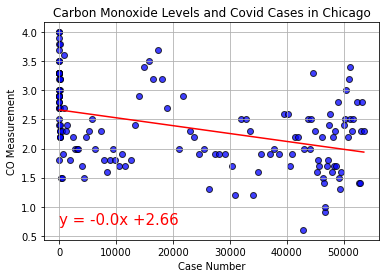

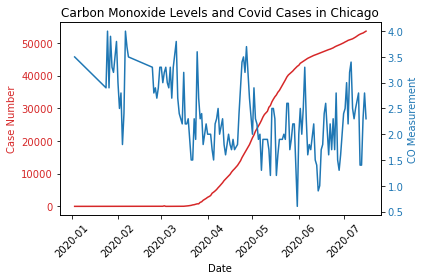

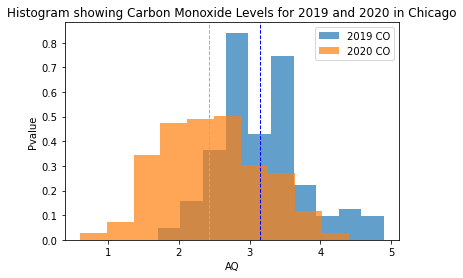

Stats for no2: Ttest_indResult(statistic=5.7225979923828705, pvalue=2.2606958493708455e-08)
The r-squared is: 0.09584697230056397
The correlation between covid cases and Air quality Pm2.5 value is -0.31


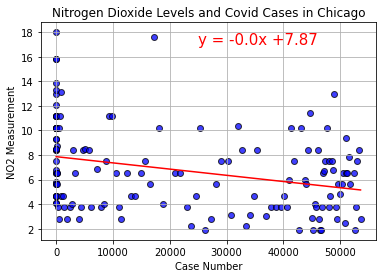

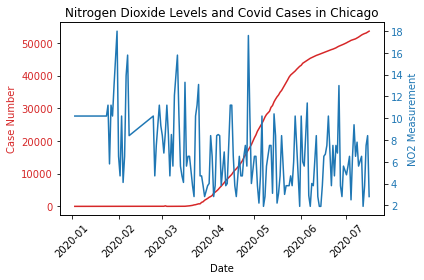

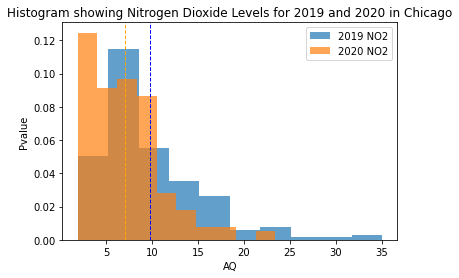

In [15]:
#----------------------------------------------------------------------------------
#Analysis of Chicago
#----------------------------------------------------------------------------------

Chiaq19 = aq_chi_final.loc[(aq_chi_final['Date']>="2019-01-01") & (aq_chi_final['Date']<="2019-07-16")]
Chiaq20 = aq_chi_final.loc[(aq_chi_final['Date']>="2020-01-01") & (aq_chi_final['Date']<="2020-07-16")]

chicompare = pd.merge(covid_chicago, aq_chi_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
#Chicago PM2.5
#----------------------------------------------------------------------------------

print(f"Stats for pm25: {st.ttest_ind(Chiaq19['pm25'], Chiaq20['pm25'], equal_var=False)}")

L_regress(chicompare['Cases'], chicompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Chicago",(20000,55),"CHIscat1")

covid_aq_plot(chicompare['Date'], chicompare['pm25'], chicompare['Cases'], "PM2.5 Measurement",
              "PM2.5 Levels and Covid Cases in Chicago", "CHIline1")

Ttest_hist(Chiaq19['pm25'], Chiaq20['pm25'], "2019 PM2.5", "2020 PM2.5",
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Chicago", "CHIhist1")

#----------------------------------------------------------------------------------
#Chicago CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Chiaq19['co'], Chiaq20['co'], equal_var=False)}")

L_regress(chicompare['Cases'], chicompare['co'], "Case Number", 'CO Measurement',
          "Carbon Monoxide Levels and Covid Cases in Chicago",(0,0.7),"CHIscat2")

covid_aq_plot(chicompare['Date'], chicompare['co'], chicompare['Cases'], "CO Measurement",
              "Carbon Monoxide Levels and Covid Cases in Chicago","CHIline2")

Ttest_hist(Chiaq19['co'], Chiaq20['co'], "2019 CO", "2020 CO",
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Chicago", "CHIhist2")

#----------------------------------------------------------------------------------
#Chicago NO2
#----------------------------------------------------------------------------------

print(f"Stats for no2: {st.ttest_ind(Chiaq19['no2'], Chiaq20['no2'], equal_var=False)}")

L_regress(chicompare['Cases'], chicompare['no2'], "Case Number", 'NO2 Measurement',
          "Nitrogen Dioxide Levels and Covid Cases in Chicago",(25000,17),"CHIscat3")

covid_aq_plot(chicompare['Date'], chicompare['no2'], chicompare['Cases'], "NO2 Measurement",
              "Nitrogen Dioxide Levels and Covid Cases in Chicago","CHIline3")

Ttest_hist(Chiaq19['no2'], Chiaq20['no2'], "2019 NO2", "2020 NO2",
           "Histogram showing Nitrogen Dioxide Levels for 2019 and 2020 in Chicago", "CHIhist3")


Stats for co: Ttest_indResult(statistic=0.8077976600995497, pvalue=0.4197136114717268)
The r-squared is: 0.0351919778435597
The correlation between covid cases and Air quality Pm2.5 value is 0.19


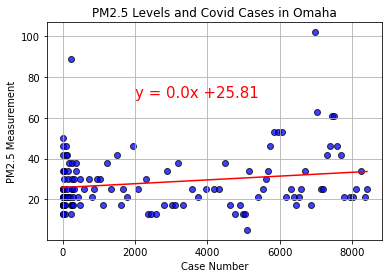

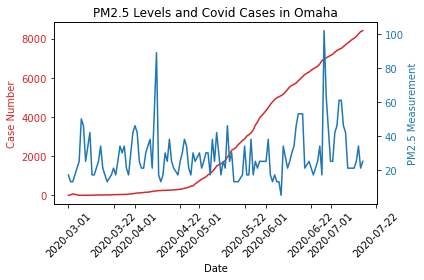

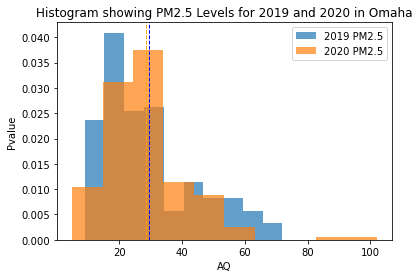

Stats for co: Ttest_indResult(statistic=-2.891602502272571, pvalue=0.0040549000963149145)
The r-squared is: 0.0003608319715825078
The correlation between covid cases and Air quality Pm2.5 value is 0.02


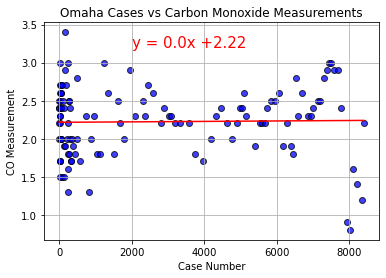

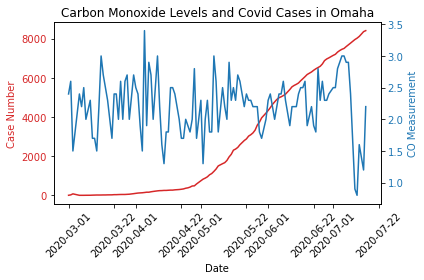

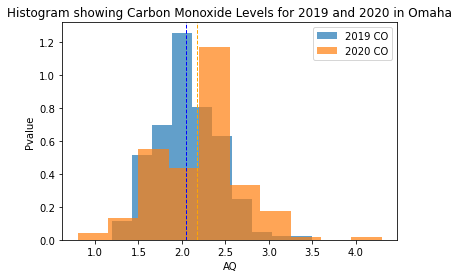

In [16]:
#----------------------------------------------------------------------------------
#Analysis of Omaha
#----------------------------------------------------------------------------------

Omaaq19 = aq_oma_final.loc[(aq_oma_final['Date']>="2019-01-01") & (aq_oma_final['Date']<="2019-07-16")]
Omaaq20 = aq_oma_final.loc[(aq_oma_final['Date']>="2020-01-01") & (aq_oma_final['Date']<="2020-07-16")]

omacompare = pd.merge(covid_omaha, aq_oma_final, how='inner', on='Date')

#----------------------------------------------------------------------------------
#Omaha PM25
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Omaaq19['pm25'], Omaaq20['pm25'], equal_var=False)}")

L_regress(omacompare['Cases'], omacompare['pm25'], "Case Number", 'PM2.5 Measurement',
          "PM2.5 Levels and Covid Cases in Omaha", (2000,70),"OMAscat1")

covid_aq_plot(omacompare['Date'], omacompare['pm25'], omacompare['Cases'], "PM2.5 Measurement",
              "PM2.5 Levels and Covid Cases in Omaha","OMAline1")

Ttest_hist(Omaaq19['pm25'], Omaaq20['pm25'], "2019 PM2.5", "2020 PM2.5",
           "Histogram showing PM2.5 Levels for 2019 and 2020 in Omaha", "OMAhist1")

#----------------------------------------------------------------------------------
#Omaha CO
#----------------------------------------------------------------------------------

print(f"Stats for co: {st.ttest_ind(Omaaq19['co'], Omaaq20['co'], equal_var=False)}")

L_regress(omacompare['Cases'], omacompare['co'], "Case Number", 'CO Measurement',
          "Omaha Cases vs Carbon Monoxide Measurements", (2000,3.2),"CHI2")

covid_aq_plot(omacompare['Date'], omacompare['co'], omacompare['Cases'], "CO Measurement",
              "Carbon Monoxide Levels and Covid Cases in Omaha","OMAline2")

Ttest_hist(Omaaq19['co'], Omaaq20['co'], "2019 CO", "2020 CO",
           "Histogram showing Carbon Monoxide Levels for 2019 and 2020 in Omaha", "OMAhist2")

#>>>>>>>>>>NOTE<<<<<<<<<<<<
#No no2 data available for Omaha